##### Importing libraries

In [150]:
# For data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# To handle data in a vectorized manner
import numpy as np

# To handle requests
import requests

# To handle JSON files
import json 
# To tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# To parse html page
from bs4 import BeautifulSoup
from bs4 import SoupStrainer

# To convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# K-means from clustering stage
from sklearn.cluster import KMeans

# Map rendering library
#!pip install folium==0.5.0
import folium 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Introduction

Moving to a new place is a very exciting, time-consuming and stressing process. Among the reasons why people move to a new place are a new job, boring neighborhood, and etc. Finding an ideal place to live is very important for many people. When looking for a new place usually people pay attention the price and to the distance to workplace or to school. Since the searching process is very time-consuming, we rarely pay attention to amenities or places that are around the neighborhood we are planning to move. Time is a very expensive commodity, and unless one has a car then moving around a new city or neighborhood is hard. Hence, sometimes people end up feeling bored in a new neighborhood. An app or website showing which of the neighborhoods in a new city are ideal for us based on our preferences and hobbies and also are close to the workplace or school would be a good solution. The target audience is people who are moving to a new city or looking for a new place to live/rent.

## 2. Data

The main data source will be Foursquare API, a social location service that allows users to explore the world around them. Using it we will access the data about the places around the neighborhoods in a city. The data will include name, category, latitude, longitude, rating, tips count, and etc. To do this we will need some information about the neighborhoods in a particular city such as name, latitude, longitude, distance. This data can be scraped from Wikipedia.

### User Data

- Assumption is that the person lives currently in Marble Hill, Manhanttan.
- He/she is moving to Toronto and will be working at IBM's downtown location. 
- He/she does yoga, loves sushi and a good coffee.

In [2]:
current_borough_name = ['Manhattan']
current_neighborhood_name = ['Marble Hill']
current_neighborhood_latitude = [40.876551]
current_neighborhood_longitude = [-73.910660]
workplace = '185 Spadina Ave, Toronto, ON'
hobbies =set(['Yoga Studio', 'Sushi Restaurant', 'Coffee Shop'])

**Note:** 
- In the app user will only be required to enter current neighborhood name, borough, workplace, and hobbies. Current neighborhood latitude and longitude will be extracted from the database. 
- Below on the example of Toronto we will show how the data about cities will be stored in the database.

### Toronto Data

In [3]:
# Requesting the data from url
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [4]:
# Condition to extract only table
only_table = SoupStrainer('table',attrs={'class':'wikitable sortable'}) # Condition to p
soup = BeautifulSoup(page,'html.parser',parse_only=only_table)
# Condition to extract rows
only_rows = SoupStrainer('tr')
# Condition to extract data from rows
def only_data(lst):
    return [[d.text.rstrip() for d in li.find_all(['td'])] for li in lst] 

data = only_data(soup.find_all(only_rows))

###### Creating a Data Frame with columns PostalCode, Borough, Neighborhood and the scraped data

In [5]:
toronto_data = pd.DataFrame(data = data, columns = ['PostalCode','Borough','Neighborhood'])[1:]

### Cleaning Toronto Data

##### Finding cells where Borough is assigned and Neighborhood is not assigned

In [6]:
toronto_data[(toronto_data['Borough'] != 'Not assigned') & (toronto_data['Neighborhood'] == 'Not assigned')]

,PostalCode,Borough,Neighborhood
9,M7A,Queen's Park,Not assigned


In [7]:
toronto_data.loc[9,'Neighborhood'] = "Queen's Park"

##### Removing rows where Borough is Not assigned

In [8]:
toronto_data = toronto_data[toronto_data['Borough'] != 'Not assigned']

###### Combining neighborhoods in one postal code area

In [9]:
toronto_data = toronto_data.groupby(['PostalCode','Borough']).Neighborhood.apply(lambda x: ', '.join(x)).reset_index()

##### Printing the shape and the first few rows of the data

In [10]:
print(toronto_data.shape)
toronto_data.head(3)

(103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"


### Geocodes of Toronto Neighborhoods

In [11]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
# Merging the toronto dataset and geo_data
toronto_data = pd.merge(toronto_data,geo_data,left_on=['PostalCode'],right_on=['Postal Code'])

In [13]:
# Dropping Postal Code since PostalCode contains the same information
toronto_data.drop(columns=['Postal Code'],inplace = True)

In [14]:
toronto_data.head(3)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711


### Exploring Neighborhoods in Toronto

Let's see how many boroughs Toronto has and what are they:

In [15]:
print('The number of boroughs in Toronto is', toronto_data.Borough.nunique())
print('They are:', toronto_data.Borough.unique())

The number of boroughs in Toronto is 11
They are: ['Scarborough' 'North York' 'East York' 'East Toronto' 'Central Toronto'
 'Downtown Toronto' 'York' 'West Toronto' "Queen's Park" 'Mississauga'
 'Etobicoke']


#### Use geopy library to get the latitude and longitude values of Toronto and workplace.

In [16]:
toronto_address = 'Toronto, ON'

geolocator = Nominatim()
toronto_location = geolocator.geocode(toronto_address)
toronto_latitude = toronto_location.latitude
toronto_longitude = toronto_location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(toronto_latitude,
                                                             toronto_longitude))
workplace_location = geolocator.geocode(workplace)
workplace_latitude = workplace_location.latitude
workplace_longitude = workplace_location.longitude
print('The geograpical coordinate of IBM are {}, {}.'.format(workplace_latitude,
                                                             workplace_longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.
The geograpical coordinate of IBM are 43.6496695, -79.3964233.


To simplify the use case, map, segment and cluster only the boroughs that contain Toronto will be chosen. So let's slice the original dataframe and create a new dataframe of the Toronto borough data.

In [17]:
toronto_list = ['East Toronto','Central Toronto','Downtown Toronto','West Toronto']
toronto = toronto_data[toronto_data['Borough'].isin(toronto_list)].reset_index(drop=True)

In [18]:
# create map of Toronto boroughs using latitude and longitude values
map_toronto = folium.Map(location = [toronto_latitude,toronto_longitude],zoom_start = 11)
# add workplace marker to map
workplace_label = folium.Popup('IBM',parse_html=True)
folium.CircleMarker([workplace_latitude,workplace_longitude],radius=7,
                     popup=workplace_label,color='red',
                     fill=True,fill_color='#cc3139',fill_opacity=0.7,
                     parse_html=False).add_to(map_toronto)

# add borough markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'],
                                           toronto['Longitude'],
                                           toronto['Borough'],
                                           toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='blue',
                        fill=True,fill_color='#3186cc',fill_opacity=0.5,
                        parse_html=False).add_to(map_toronto)

map_toronto

![Image One](https://github.com/ssuleyma/Coursera_Capstone/blob/master/Capstone_Images/IMG_One.png?raw=true "Image One")

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [19]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

### Exploring current neighbourhood and neighborhoods in selected boroughs 

#### Let's create a function that will extract the data from Foursquare and return a dataframe

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Venue ID',           
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

#### Run the function above for the Current Neigborhood

In [21]:
current_venues = getNearbyVenues(names=current_neighborhood_name,
                                 latitudes=current_neighborhood_latitude,
                                 longitudes=current_neighborhood_longitude)

Marble Hill


#### Run the function above for each of the Toronto Neighborhoods

In [22]:
ns = toronto['Neighborhood']
lts = toronto['Latitude']
lgs = toronto['Longitude']
toronto_venues = getNearbyVenues(names=ns,latitudes=lts,longitudes=lgs)

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

#### Let's check the size of the resulting dataframes

In [23]:
print(current_venues.shape)
current_venues.head(3)

(24, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,4b4429abf964a52037f225e3,40.874412,-73.910271,240,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,4baf59e8f964a520a6f93be3,40.876844,-73.906204,376,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,4b79cc46f964a520c5122fe3,40.880404,-73.908937,452,Diner


In [24]:
print(toronto_venues.shape)
toronto_venues.head(3)

(1700, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,The Beaches,43.676357,-79.293031,Grover Pub and Grub,4b8daea1f964a520480833e3,43.679181,-79.297215,460,Pub
1,The Beaches,43.676357,-79.293031,Starbucks,4e77e3861f6ecf8d3648300c,43.678798,-79.298045,486,Coffee Shop
2,The Beaches,43.676357,-79.293031,Guru Raghavendra Ji,5c125491ad1789002d4eda71,43.680187,-79.292337,429,Astrologer


#### Let's find out how many unique categories can be curated from all the returned Marble Hill venues

In [25]:
print('There are {} uniques categories.'.format(len(current_venues['Venue Category'].unique())))

There are 22 uniques categories.


#### Let's find out how many unique categories can be curated from all the returned Toronto venues

In [26]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


## 3. Methodology

- K-means clustering will be used to find neighborhoods in Toronto that are similar to Marble Hill
- For the neigborhoods that are similar to Marble Hill additional filtering will be applied based on person's hobbies
- Lastly, we will check which neighborhoods are closer to the workplace and sort our results based on the distance

### Clustering

#### Merging current and Toronto neighborhoods

In [27]:
all_venues = current_venues.append(toronto_venues,ignore_index=True)

In [28]:
# one hot encoding
all_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
all_onehot['Neighborhood'] = all_venues['Neighborhood'] 

And let's examine the new dataframe size.

In [29]:
all_onehot.shape

(1724, 241)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
all_grouped = all_onehot.groupby('Neighborhood').mean().reset_index()
all_grouped.head(3) 

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.010000,0.01,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.000000,0.030000,0.0,0.03,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.02,0.0,0.01,0.02,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.0,0.050000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.030000,0.010000,0.060000,0.0,0.0,0.0,0.000000,0.0,0.020000,0.00,0.020000,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0

#### Let's confirm the new size

In [31]:
all_grouped.shape

(39, 241)

#### Let's print each neighborhood along with the top 5 most common venues

In [32]:
num_top_venues = 5

for hood in all_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = all_grouped[all_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2           Steakhouse  0.04
3  American Restaurant  0.04
4      Thai Restaurant  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1          Restaurant  0.06
2        Cocktail Bar  0.06
3                 Pub  0.04
4  Italian Restaurant  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0  Breakfast Spot  0.10
1            Café  0.10
2     Coffee Shop  0.10
3             Gym  0.05
4   Burrito Place  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.12
1                 Spa  0.06
2          Restaurant  0.06
3         Pizza Place  0.06
4          Smoke Shop  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.14
1   Air

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = all_grouped['Neighborhood']

for ind in np.arange(all_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Hotel,Restaurant,Gym,Bar,Clothing Store
1,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Farmers Market,Cheese Shop,Café,Pub,Steakhouse,Seafood Restaurant,Italian Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Gym / Fitness Center,Furniture / Home Store,Convenience Store,Climbing Gym,Nightclub,Caribbean Restaurant,Burrito Place
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Pizza Place,Garden,Comic Shop,Butcher,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Airport Service,Plane,Sculpture Garden,Boutique,Boat or Ferry,Airport Gate,Airport Food Court,Airport
5,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Park,Bakery,Italian Restaurant,Pub,Café,Pizza Place,Pharmacy,Breakfast Spot
6,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Ice Cream Shop,Burger Joint,Bar,Falafel Restaurant,Spa,Chinese Restaurant,Salad Place
7,"Chinatown, Grange Park, Kensington Market",Café,Bar,Vegetarian / Vegan Restaurant,Coffee Shop,Dumpling Restaurant,Vietnamese Restaurant,Bakery,Chinese Restaurant,Mexican Restaurant,Dessert Shop
8,Christie,Grocery Store,Café,Park,Convenience Store,Nightclub,Baby Store,Diner,Athletics & Sports,Italian Restaurant,Restaurant
9,Church and Wellesley,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Gay Bar,Restaurant,Burger Joint,Café,Pub,Men's Store,Mediterranean Restaurant


#### Applying K-means algorithm

In [35]:
all_grouped.head(3)

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.010000,0.01,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.000000,0.030000,0.0,0.03,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.02,0.0,0.01,0.02,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.0,0.050000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.030000,0.010000,0.060000,0.0,0.0,0.0,0.000000,0.0,0.020000,0.00,0.020000,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0

Let's first identify the number of optimum clusters by using the elbow rule

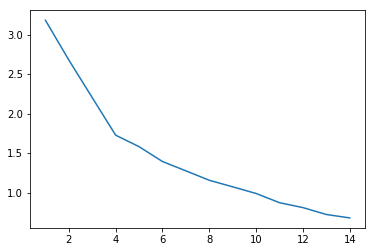

In [36]:
K = range(1,15)
all_grouped_clustering = all_grouped.drop('Neighborhood', 1)
wcss = [KMeans(n_clusters=i,random_state=0).fit(all_grouped_clustering ).inertia_ for i in K]
plt.plot(range(1,15),wcss)

Run *k*-means to cluster the neighborhoods into 7 clusters based on Elbow Rule.

In [37]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
all_data = toronto.append({'PostalCode': 'NA', 'Borough': current_borough_name[0],
                           'Neighborhood': current_neighborhood_name[0], 
                           'Latitude': current_neighborhood_latitude[0], 
                           'Longitude': current_neighborhood_longitude[0]},
                          ignore_index=True)

In [39]:
all_merged = all_data

# add clustering labels
all_merged['Cluster Labels'] = kmeans.labels_

# merge neighborhoods_venues_sorted with toronto to add latitude/longitude for each neighborhood
all_merged = all_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

all_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Astrologer,Coffee Shop,Pub,Yoga Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bookstore,Yoga Studio,Juice Bar,Pub,Caribbean Restaurant,Bakery
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Park,Intersection,Pet Store,Pizza Place,Movie Theater,Pub,Burrito Place,Sandwich Place,Burger Joint,Brewery
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Yoga Studio,Bakery,Italian Restaurant,American Restaurant,Middle Eastern Restaurant,Juice Bar,Fish Market,Bookstore
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Bus Line,Park,Swim School,Dim Sum Restaurant,Yoga Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


Let's see which cluster Marble Hill is in and which neighborhoods in Toronto are similar to Marble Hill.

In [40]:
print('The Marble Hill is in cluster', int(all_merged.loc[all_merged['Neighborhood'] == 'Marble Hill','Cluster Labels']))

The Marble Hill is in cluster 1


In [41]:
similar_neighborhoods = all_merged.copy().loc[(all_merged['Cluster Labels'] == 1) & (all_merged['Neighborhood'] != 'Marble Hill')]
print('There are {} other neighborhoods in that cluster:'.format(len(similar_neighborhoods)))
similar_neighborhoods

There are 29 other neighborhoods in that cluster:


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Astrologer,Coffee Shop,Pub,Yoga Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bookstore,Yoga Studio,Juice Bar,Pub,Caribbean Restaurant,Bakery
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Park,Intersection,Pet Store,Pizza Place,Movie Theater,Pub,Burrito Place,Sandwich Place,Burger Joint,Brewery
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Yoga Studio,Bakery,Italian Restaurant,American Restaurant,Middle Eastern Restaurant,Juice Bar,Fish Market,Bookstore
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Bus Line,Park,Swim School,Dim Sum Restaurant,Yoga Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1,Hotel,Food & Drink Shop,Sandwich Place,Gym,Breakfast Spot,Park,Burger Joint,Doner Restaurant,Donut Shop,Dumpling Restaurant
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1,Clothing Store,Coffee Shop,Sporting Goods Shop,Yoga Studio,Bagel Shop,Chinese Restaurant,Dessert Shop,Rental Car Location,Diner,Salon / Barbershop
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,1,Dessert Shop,Sandwich Place,Pizza Place,Pharmacy,Restaurant,Café,Coffee Shop,Sushi Restaurant,Seafood Restaurant,Italian Restaurant
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,1,Playground,Restaurant,Yoga Studio,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,1,Coffee Shop,Pub,Pizza Place,Sushi Restaurant,Fried Chicken Joint,Supermarket,Bagel Shop,Sports Bar,American Restaurant,Convenience Store


Finally, let's visualize the resulting clusters

In [42]:
# create map of Toronto boroughs using latitude and longitude values
map_toronto = folium.Map(location = [toronto_latitude,toronto_longitude],zoom_start = 10)
# add workplace marker to map
workplace_label = folium.Popup('IBM',parse_html=True)
folium.CircleMarker([workplace_latitude,workplace_longitude],radius=7,
                     popup=workplace_label,color='red',
                     fill=True,fill_color='#cc3139',fill_opacity=0.7,
                     parse_html=False).add_to(map_toronto)

# add borough markers to map
for lat, lng, borough, neighborhood in zip(similar_neighborhoods['Latitude'],
                                           similar_neighborhoods['Longitude'],
                                           similar_neighborhoods['Borough'],
                                           similar_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='green',
                        fill=True,fill_color='#3186cc',fill_opacity=0.5,
                        parse_html=False).add_to(map_toronto)

map_toronto

![Image Two](https://github.com/ssuleyma/Coursera_Capstone/blob/master/Capstone_Images/IMG_Two.png?raw=true "Image Two")

30 similar neighborhoods! It seems many neighborhoods in Toronto are similar to Marble Hill.

### Filtering based on Hobbies

#### The function below will filter similar neighborhoods based on person's hobbies. The neighborhood should contain venues that match at least 2 hobbies. 

In [57]:
def hobbies_filter(n_data, v_data, hs):
    similar_n_data_filter = v_data[v_data['Neighborhood'].isin(list(n_data.Neighborhood.unique()))]
    v_category_grouped = similar_n_data_filter.groupby(by=['Neighborhood'])['Venue Category'].apply(set).reset_index()
    v_category_grouped['Common Venues'] = v_category_grouped['Venue Category'].apply(lambda a:  a&hs)
    hs_filter = v_category_grouped[v_category_grouped['Common Venues'].apply(lambda s: True if len(s)>=2 else False)]
    similar_n_data = n_data[n_data['Neighborhood'].isin(hs_filter['Neighborhood'].unique())]
    filtered_venues = v_data[(v_data['Neighborhood'].isin(hs_filter['Neighborhood'])) & (v_data['Venue Category'].isin(hs))]
    return filtered_venues, similar_n_data

filter_venues, similar_data = hobbies_filter(similar_neighborhoods, toronto_venues, hobbies)

#### This function will get rating for each venue from Foursquare API

In [63]:
def venue_rating(v_id):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(v_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        return result['response']['venue']['rating']
    except:
        return -1

filter_venues['Venue Rating'] = filter_venues['Venue ID'].apply(venue_rating)

#### Let's now sort the venues based on rating. If there is No rating for venue it will be indicated as -1 and that venue will be the last element.

In [102]:
filter_venues = filter_venues.sort_values(by=['Neighborhood','Venue Rating'],ascending=False).reset_index(drop=True)
filter_venues.dropna(inplace=True)
filter_venues['Venue and Rating'] = filter_venues['Venue'] + ' : ' + filter_venues['Venue Rating'].astype('str')
filter_venues_data = filter_venues.groupby(by= ['Neighborhood'])['Venue and Rating'].apply(list).reset_index()

In [122]:
filter_venues['Venue and Rating'] = filter_venues['Venue'] + '-' + filter_venues['Venue Category'] + ' : ' + filter_venues['Venue Rating'].astype('str')
filter_venues_data = filter_venues.groupby(by= ['Neighborhood'])['Venue and Rating'].apply(list).reset_index()

#### For each of the neighborhoods that are left after filtering based on hobbies we created a list of venues that person should attend sorted based on rating. The final dataframe looks like this:

In [123]:
filter_venues_data

,Neighborhood,Venue and Rating
0,"Adelaide, King, Richmond","[JaBistro-Sushi Restaurant : 8.8, Starbucks-Co..."
1,Davisville,"[Sakae Sushi-Sushi Restaurant : 7.6, Hokkaido ..."
2,"Deer Park, Forest Hill SE, Rathnelly, South Hi...","[Daeco Sushi-Sushi Restaurant : 7.4, Starbucks..."
3,"Harbourfront East, Toronto Islands, Union Station","[Pilot Coffee Roasters-Coffee Shop : 8.9, Balz..."
4,"Little Portugal, Trinity","[YogaSpace-Yoga Studio : -1.0, i deal coffee-C..."
5,North Toronto West,"[Barreworks-Yoga Studio : 7.7, Starbucks-Coffe..."
6,St. James Town,"[Fahrenheit Coffee-Coffee Shop : 9.2, Versus C..."
7,Studio District,"[Te Aro-Coffee Shop : 8.9, Mercury Espresso Ba..."
8,"The Danforth West, Riverdale","[Moksha Yoga Danforth-Yoga Studio : 8.0, Cafe ..."


In [128]:
for i in filter_venues_data['Neighborhood']:
    print(i)
    for j in (filter_venues_data.loc[filter_venues_data['Neighborhood'] == i,'Venue and Rating']):
        print(j)
    print("\n")

Adelaide, King, Richmond
['JaBistro-Sushi Restaurant : 8.8', 'Starbucks-Coffee Shop : 8.4', 'M Square Coffee Co-Coffee Shop : 8.3', 'Pilot Coffee Roasters-Coffee Shop : 8.2', 'Yuzu No Hana-Sushi Restaurant : 8.2', 'Dineen @CommerceCourt-Coffee Shop : 7.9', 'Starbucks-Coffee Shop : 7.8', 'HotBlack Coffee-Coffee Shop : 7.7']


Davisville
['Sakae Sushi-Sushi Restaurant : 7.6', 'Hokkaido Sushi-Sushi Restaurant : 7.5', 'Starbucks-Coffee Shop : 7.4', 'Second Cup-Coffee Shop : 6.0']


Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
['Daeco Sushi-Sushi Restaurant : 7.4', 'Starbucks-Coffee Shop : 6.4', 'Tim Hortons-Coffee Shop : 6.3']


Harbourfront East, Toronto Islands, Union Station
['Pilot Coffee Roasters-Coffee Shop : 8.9', "Balzac's Coffee-Coffee Shop : 8.1", 'Tim Hortons-Coffee Shop : 7.8', 'Starbucks-Coffee Shop : 7.7', 'Gonoe Sushi Japanese Restaurant-Sushi Restaurant : 7.6', 'Starbucks-Coffee Shop : 7.5', 'Starbucks-Coffee Shop : 7.5', 'Lavazza Espression-Coffee Shop

##### Let's now visualize these neigborhoods on map

In [124]:
# create map of Toronto boroughs using latitude and longitude values
map_toronto = folium.Map(location = [toronto_latitude,toronto_longitude],zoom_start = 12)
# add workplace marker to map
workplace_label = folium.Popup('IBM',parse_html=True)
folium.CircleMarker([workplace_latitude,workplace_longitude],radius=7,
                     popup=workplace_label,color='red',
                     fill=True,fill_color='#cc3139',fill_opacity=0.7,
                     parse_html=False).add_to(map_toronto)

# add borough markers to map
for lat, lng, borough, neighborhood in zip(similar_data['Latitude'],
                                           similar_data['Longitude'],
                                           similar_data['Borough'],
                                           similar_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='purple',
                        fill=True,fill_color='#8e225d',fill_opacity=0.5,
                        parse_html=False).add_to(map_toronto)

map_toronto

![Image Three](https://github.com/ssuleyma/Coursera_Capstone/blob/master/Capstone_Images/IMG_Three.png?raw=true "Image three")

### Sorting based on Distance to Workplace

#### First we need to calculate the distance from each neighborhood to person's workplace. We will use geopy  library to do this. An example is below:

In [137]:
import geopy.distance

coords_1 = (workplace_latitude, workplace_longitude)
coords_2 = (43.679557, -79.352188) # The Danforth West, Riverdale latitude and longitude

print("The distance from The Danforth West, Riverdale to IBM is {} km".format(np.round(geopy.distance.vincenty(coords_1, coords_2).km,decimals=2)))

The distance from The Danforth West, Riverdale to IBM is 4.87 km


#### Let's create a function, which will calculate distance to workplace for each of the neighborhoods

In [140]:
def workplace_dist(coords):
    coords_1 = (workplace_latitude, workplace_longitude)
    coords_2 = coords
    return np.round(geopy.distance.vincenty(coords_1, coords_2).km,decimals=2)

#### Let's apply the function above to each of the neighborhoods

In [151]:
similar_data['Lat Long'] = list(zip(similar_data.Latitude, similar_data.Longitude))
similar_data['Dist to Work'] = similar_data['Lat Long'].apply(workplace_dist)

#### Finally, let's sort the neighborhoods based on the distance to workplace and print the 5 closest neigborhoods that contain venues matching person's hobbies:

In [157]:
final_result = pd.merge(similar_data.copy()[['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude','Dist to Work']],
                      filter_venues_data.copy(), on = 'Neighborhood')
final_result.sort_values(by=['Dist to Work'],inplace=True)

In [190]:
final_result.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Dist to Work,Venue and Rating
6,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,0.96,"[JaBistro-Sushi Restaurant : 8.8, Starbucks-Co..."
7,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,1.54,"[Pilot Coffee Roasters-Coffee Shop : 8.9, Balz..."
5,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1.71,"[Fahrenheit Coffee-Coffee Shop : 9.2, Versus C..."
8,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,1.89,"[YogaSpace-Yoga Studio : -1.0, i deal coffee-C..."
4,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,4.09,"[Daeco Sushi-Sushi Restaurant : 7.4, Starbucks..."


## 4. Results

In [191]:
print("Here are the 5 closest neighborhoods that match your interests along with the top 5 places in each neighborhood that we hope you will enjoy: \n")
for n,d,v in (zip(final_result.head(5)['Neighborhood'],final_result.head(5)['Dist to Work'],final_result.head(5)['Venue and Rating'])):
    print('{} is {} km away from IBM and the places you should check out are : \n'.format(n,d))
    for i in v[:5]:
        print(i)
    print('-----------------------------------------------------------------------------------\n')

Here are the 5 closest neighbourhoods that match your interests along with the top 5 places in each neighbourhood that we hope you will enjoy: 

Adelaide, King, Richmond is 0.96 km away from IBM and the places you should check out are : 

JaBistro-Sushi Restaurant : 8.8
Starbucks-Coffee Shop : 8.4
M Square Coffee Co-Coffee Shop : 8.3
Pilot Coffee Roasters-Coffee Shop : 8.2
Yuzu No Hana-Sushi Restaurant : 8.2
-----------------------------------------------------------------------------------

Harbourfront East, Toronto Islands, Union Station is 1.54 km away from IBM and the places you should check out are : 

Pilot Coffee Roasters-Coffee Shop : 8.9
Balzac's Coffee-Coffee Shop : 8.1
Tim Hortons-Coffee Shop : 7.8
Starbucks-Coffee Shop : 7.7
Gonoe Sushi Japanese Restaurant-Sushi Restaurant : 7.6
-----------------------------------------------------------------------------------

St. James Town is 1.71 km away from IBM and the places you should check out are : 

Fahrenheit Coffee-Coffee Sho

#### Let's visualize those neighborhoods on map

In [189]:
# create map of Toronto boroughs using latitude and longitude values
map_toronto = folium.Map(location = [toronto_latitude,toronto_longitude],zoom_start = 13)
# add workplace marker to map
workplace_label = folium.Popup('IBM',parse_html=True)
folium.CircleMarker([workplace_latitude,workplace_longitude],radius=7,
                     popup=workplace_label,color='red',
                     fill=True,fill_color='#cc3139',fill_opacity=0.7,
                     parse_html=False).add_to(map_toronto)

# add borough markers to map
for lat, lng, borough, neighborhood in zip(final_result.head(5)['Latitude'],
                                           final_result.head(5)['Longitude'],
                                           final_result.head(5)['Borough'],
                                           final_result.head(5)['Neighborhood']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='green',
                        fill=True,fill_color='#068481',fill_opacity=0.9,
                        parse_html=False).add_to(map_toronto)

map_toronto

![Image Four](https://github.com/ssuleyma/Coursera_Capstone/blob/master/Capstone_Images/IMG_Four.png?raw=true "Image Four")

**Note:**

In [197]:
print('In total there are {} neighborhoods that match all the requirements. In the above case we chose only the top 5.'.format(len(final_result)))

print("Let's print all matching neighborhoods:")

In total there are 9 neighborhoods that match all the requirements. In the above case we chose only the top 5.
Let's print all matching neighbourhoods:


In [199]:
for n,d,v in (zip(final_result['Neighborhood'],final_result['Dist to Work'],final_result['Venue and Rating'])):
    print('{} is {} km away from IBM and the places you should check out are : \n'.format(n,d))
    for i in v:
        print(i)
    print('-----------------------------------------------------------------------------------\n')

Adelaide, King, Richmond is 0.96 km away from IBM and the places you should check out are : 

JaBistro-Sushi Restaurant : 8.8
Starbucks-Coffee Shop : 8.4
M Square Coffee Co-Coffee Shop : 8.3
Pilot Coffee Roasters-Coffee Shop : 8.2
Yuzu No Hana-Sushi Restaurant : 8.2
Dineen @CommerceCourt-Coffee Shop : 7.9
Starbucks-Coffee Shop : 7.8
HotBlack Coffee-Coffee Shop : 7.7
-----------------------------------------------------------------------------------

Harbourfront East, Toronto Islands, Union Station is 1.54 km away from IBM and the places you should check out are : 

Pilot Coffee Roasters-Coffee Shop : 8.9
Balzac's Coffee-Coffee Shop : 8.1
Tim Hortons-Coffee Shop : 7.8
Starbucks-Coffee Shop : 7.7
Gonoe Sushi Japanese Restaurant-Sushi Restaurant : 7.6
Starbucks-Coffee Shop : 7.5
Starbucks-Coffee Shop : 7.5
Lavazza Espression-Coffee Shop : 7.1
Aroma Espresso Bar-Coffee Shop : 7.1
Starbucks-Coffee Shop : 7.0
Starbucks-Coffee Shop : 7.0
Starbucks-Coffee Shop : 6.9
Tim Hortons-Coffee Shop : 

# END